## Defect Detection in STEM Images of MoS2 Monolayers

#### In this notebook, we will...
- Apply preprocessing steps to each image
- Collate images and corresponding manual annotations
- Split the data into training and testing sets
- Upload the training set of images to Azure Custom Vision
- Assess the intensity profile of a defect

#### We start by importing all the required packages and some helper classes:

In [1]:
import os
import cv2
from util import labeledImage
from azureapi import AzureCVObjectDetectionAPI
from sklearn.model_selection import train_test_split
from skimage import io, filters, exposure, measure
import numpy as np
from matplotlib import pyplot as plt

#### Apply some preprocessing steps to each image using the `scitkit-image` package:
1. A gaussian blur filter is applied to remove gaussian noise from the image  
2. A contrast limited adaptive histogram equalization algorithm is applied to locally enhance image contrast

*Note: this cell only needs to be run a single time!* 

In [2]:
for num in range(1,29):
    image = cv2.imread(f'data/mos2/{num}.png')
    denoised_image = filters.gaussian(image, sigma=1)
    adjusted_image = exposure.equalize_adapthist(denoised_image)
    adjusted_image = (adjusted_image * 255).astype(np.uint8)
    cv2.imwrite(f'data/mos2_pp/{num}.png', adjusted_image)

#### Load images and corresponding labels into `labeledImage` objects:
*Note: the `preprocessing` flag allows you to choose whether or not the loaded images have been preprocessed.*

In [3]:
preprocessing = False

if preprocessing:
    img_dir = './data/mos2_pp/'
else:
    img_dir = './data/mos2/'
labels_dir = './data/labels/'

labeled_images = []
tag = 'molecule'
img_fns = os.listdir(img_dir)
for file in img_fns:
    if file.endswith(".png"):
        image_path = os.path.join(img_dir, file)
        label_path = os.path.join(labels_dir, file.split('.')[0] + '.txt')
        labeled_images.append(labeledImage(image_path))
        labeled_images[-1].add_labels_from_file(tag, label_path)

#### Print information about a labeled image to ensure all data is correct:

In [4]:
print(labeled_images[0])

Labeled image 1.png
    location: ./data/mos2/1.png
    shape: (1024, 1024, 3)
    labels:
    - molecule: 
      [379, 513, 81, 72]
      [780, 84, 80, 47]
      [175, 153, 45, 30]
      [455, 132, 42, 36]
      [449, 165, 36, 38]
      [383, 356, 46, 44]
      [136, 616, 44, 32]
      [151, 580, 34, 28]
      [691, 707, 41, 65]
      [733, 693, 68, 52]
      [740, 904, 55, 65]
      [601, 819, 59, 40]
      [335, 743, 50, 37]
      [565, 687, 103, 42]
      [729, 493, 80, 34]
      [995, 125, 29, 74]
      [243, 445, 66, 67]
      [596, 404, 59, 45]
      [583, 441, 69, 51]
      [728, 425, 65, 47]



#### Split images into training and testing sets:
- The training images will be uploaded to Azure Custom Vision to train the object detection model
- The testing images will be used to validate the model after training is complete

In [5]:
train_images, test_images = train_test_split(labeled_images, test_size=0.2, random_state=42)

train_image_numbers = [int(img.name.split('.')[0]) for img in train_images]
test_image_numbers = [int(img.name.split('.')[0]) for img in test_images]
print(f'Training Images: {train_image_numbers}')
print(f'Testing Images: {test_image_numbers}')

Training Images: [25, 4, 2, 21, 23, 10, 13, 14, 11, 24, 5, 12, 8, 6, 26, 9, 28, 16, 19, 22, 27, 15]
Testing Images: [18, 7, 17, 3, 1, 20]


#### Upload the training images to Azure Custom Vision:
*Note: two projects are created, one for the model trained on preprocessed images and one for the model trained on raw images.*

In [9]:
# create AzureAPI object and upload images, destination depending on whether preprocessing was done #
if preprocessing:
    Project_Id  = '2f86d5ff-8fe2-4668-bb5e-5d8d466dc1b9'
else:
    Project_Id  = '5ce9e36e-942f-45c5-a102-837662335aa6'

Endpoint    = 'https://southcentralus.api.cognitive.microsoft.com/'
Key         = 'dc7af5f887c84f90a51d25549c7ad863'
Resource_Id = '/subscriptions/cbcd0d6a-0ae5-48a7-a46d-4a4f3c692c71/resourceGroups/rg-amlclass-longnic/providers/Microsoft.CognitiveServices/accounts/cv_longnic'

ACVObjectDetector = AzureCVObjectDetectionAPI(Endpoint, Key, Resource_Id, Project_Id)
ACVObjectDetector.upload_training_images(train_images)

Adding images...
Adding images: batch  1
Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate


#### Intensity Profiling

We're going to draw a line through a predicted defect and look at the intensity spectrum. This will help us characterize our defects. First let's grab a prediction image.

In [7]:
# get prediction image
cwd = os.getcwd()
image = io.imread(cwd + '/preds/pred1.png')

Now we'll create a *profile line* and measure the RBG values along the line, and plot the results!

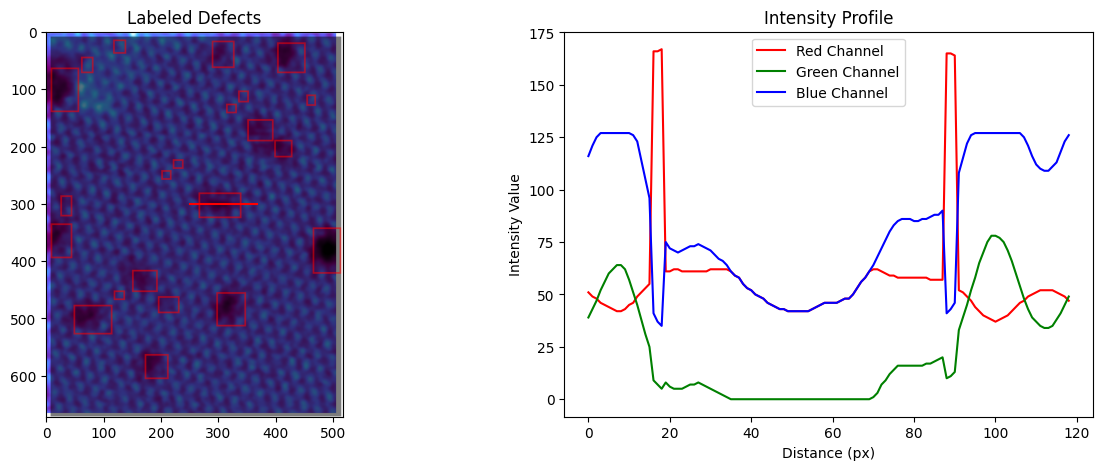

In [8]:
# draw line for profiling
start = (300, 250)
end = (300, image.shape[1] - 150)
profile = measure.profile_line(image, start, end)

# measure each channel
profile_red = measure.profile_line(image[:, :, 0], start, end)
profile_green = measure.profile_line(image[:, :, 1], start, end)
profile_blue = measure.profile_line(image[:, :, 2], start, end)

# plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Labeled Defects')
ax[0].imshow(image)
ax[0].plot([start[1], end[1]], [start[0], end[0]], 'r')
ax[1].set_title('Intensity Profile')
ax[1].plot(profile_red, 'r', label='Red Channel')
ax[1].plot(profile_green, 'g', label='Green Channel')
ax[1].plot(profile_blue, 'b', label='Blue Channel')
ax[1].set_ylabel('Intensity Value')
ax[1].set_xlabel('Distance (px)')
ax[1].legend()

plt.show()